In [7]:
%matplotlib inline

import os

import gym
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

from models.vae import get_vae
from models.rnn import get_rnn

In [9]:
data_shape = (64, 64, 3)
latent_dim = 32
data_dir = 'data/'
checkpoint_path = 'checkpoints/vae.h5'
num_images = 5

In [5]:
vae = get_vae(data_shape, latent_dim)
vae.load_weights(checkpoint_path)

In [20]:
filelist = os.listdir(data_dir)
filelist.sort()
filename = filelist[0]
obs = np.load(os.path.join(data_dir, filename))['obs'].astype(np.float) / 255.
np.random.shuffle(obs)
obs = obs[:num_images]

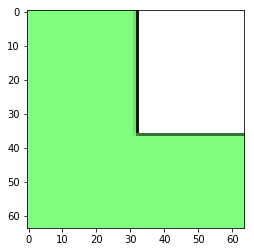

In [28]:
plt.imshow(obs[0])